## Importando dependêndencias

In [10]:

# Importando bibliotecas
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from Modules.Helper import Helper
from Modules.Solvers import Solvers
from Modules.Plotters import Plotters
import pandas as pd
from Modules.Equation import Equation

# Modelos de 5 variáveis

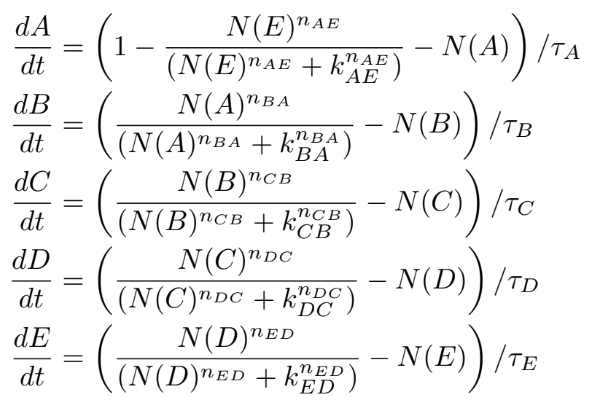

## Carregamento de Dados do Arquivo

In [11]:
labels = ['A', 'B', 'C', 'D', 'E']
df, max_data = Helper.load_data(filename='Data/GRN5_DATA.txt', labels=labels)

## Definindo variáveis, coeficientes e valores iniciais

In [12]:
# ind_atual = [1.2163355099083872, 1.1264485098219865, 2.973714367061704, 2.952143123315177, 2.998260518457365, 0.5687249950503857, 0.4580723119903261, 0.46214892372246563, 0.6182568295500336, 0.5213082492659304, 0.7708877748759901, 0.1497642024548283, 4.254757908429968, 3.759370669969996, 4.784173526119725, 10.935884810737809, 24.595975874929724, 2.8109199678182635, 4.922623602327875, 1.804297289687443, 0.6961641316460799, 1.1805067448542073, 3.769380877770944, 0.6268588518301711, 0.7945926074279098, 0.8665901143646684, 1.1631405647512596, 2.3141178250393146, 1.2841062086785697, 0.7091739090057955, 2.245324305294896, 0.8208096283146853, 0.6911548119817139, 0.7874359961268611, 1.101498884676361, 0.7742237807425528, 0.9816157239798934, 70.97756457350062]

tauA = 1.2163355099083872
tauB = 1.1264485098219865
tauC = 2.973714367061704
tauD = 2.952143123315177
tauE = 2.998260518457365
kAE = 0.5687249950503857
kBA = 0.4580723119903261
kCB = 0.46214892372246563
kDC = 0.6182568295500336
kEB = 0.5213082492659304
kED = 0.7708877748759901
kEE = 0.1497642024548283
nAE = 4.254757908429968
nBA = 3.759370669969996
nCB = 4.784173526119725
nDC = 10.935884810737809
nEB = 24.595975874929724
nED = 2.8109199678182635
nEE = 4.922623602327875

In [13]:
# Coeficientes do Modelo
# nAE, kAE, tauA = 13, 0.72, 1.25
# nBA, kBA, tauB = 4, 0.5, 4
# nCB, kCB, tauC = 3, 0.45, 1.02
# nDC, kDC, tauD = 4, 0.51, 1.57
# nED, kED, tauE = 16, 0.52, 3.42

coefficients = {
    'A': {
        'E': {
            'n': nAE,
            'k': kAE,
            '-': True,
        },
        'tau': tauA
    },
    'B': {
        'A': {
            'n': nBA,
            'k': kBA,
            '-': False,
        },
        'tau': tauB
    },
    'C': {
        'B': {
            'n': nCB,
            'k': kCB,
            '-': False,
        },
        'tau': tauC
    },
    'D': {
        'C': {
            'n': nDC,
            'k': kDC,
            '-': False,
        },
        'tau': tauD
    },
    'E': {
        'D': {
            'n': nED,
            'k': kED,
            '-': False,
        },
        'B': {
            'n': nEB,
            'k': kEB,
            '-': False,
        },
        'E': {
            'n': nEE,
            'k': kEE,
            '-': False,
        },
        'tau': tauE
    }
}

# Condições iniciais
initial_conditions = [df[label].iloc[0] for label in labels]


# Intervalo de tempo
t_span = (0, 72)
h = 0.01
t_eval = np.linspace(*t_span, int((t_span[1]-t_span[0])/h))

#metodos
methods = ['Euler', 'RK6', 'RK45', 'RK23', 'DOP853', 'LSODA', 'BDF']

equation = Equation(coefficients=coefficients, labels=labels)


## Declarações de funções

In [14]:
# Sistema de EDOs
# def system(t, y):
#     vals = [Solvers.norm_hardcoded(val, max_data[label]) for val, label in zip(y, labels)]
#     N_A, N_B, N_C, N_D, N_E = vals
    
#     # dA = (1 - (N_E**nAE / (N_E**nAE + kAE**nAE)) - N_A) / tauA
#     # dB = ((N_A**nBA / (N_A**nBA + kBA**nBA)) - N_B) / tauB
#     # dC = ((N_B**nCB / (N_B**nCB + kCB**nCB)) - N_C) / tauC
#     # dD = ((N_C**nDC / (N_C**nDC + kDC**nDC)) - N_D) / tauD
#     # dE = ((N_D**nED / (N_D**nED + kED**nED)) - N_E) / tauE
    
#     dA = equation.full_eq(vals, 'A', 'E')
#     dB = equation.full_eq(vals, 'B', 'A')
#     dC = equation.full_eq(vals, 'C', 'B')
#     dD = equation.full_eq(vals, 'D', 'C')
#     dE = equation.full_eq(vals, 'E', 'D')
    
    
#     return [dA, dB, dC, dD, dE]


def system(t, y):
    vals = [Solvers.norm_hardcoded(val, max_data[label]) for val, label in zip(y, labels)]
    N_A, N_B, N_C, N_D, N_E = vals
    
    dA = equation.full_eq(vals, 'A', 'E')
    dB = equation.full_eq(vals, 'B', 'A')
    dC = equation.full_eq(vals, 'C', 'B')
    dD = equation.full_eq(vals, 'D', 'C')
    dE = equation.complex_eqs(vals, 'E', [['+B', '+D'], ['+D', '+E']])
    
    # dE = ((
    #         (((N_B**nEB)/((N_B**nEB) + (kEB**nEB))) * ((N_D**nED)/((N_D**nED) + (kED**nED)))) 
    #         +
    #         (((N_D**nED)/((N_D**nED) + (kED**nED)))*((N_E**nEE)/((N_E**nEE) + (kEE**nEE))))) - (N_E)
    #     ) / tauE

    return [dA, dB, dC, dD, dE]

# Simulaçoes

In [30]:
# Resolução dos métodos
results = {}

for method in methods:
    if method != 'Euler' and method != 'RK6':
        results[method] = solve_ivp(system, t_span, initial_conditions, method=method, t_eval=t_eval).y
    else:
        results[method] = Solvers.solve_manual(fun=system, y0=initial_conditions,method=method, t_eval=t_eval, h=h)

In [16]:

#benchmark para outras EDOS


# import math
# def system(t, y):
#     return [0.5*t]
# sol = solve_ivp(system, t_span, [0], method=method, t_eval=t_eval)
# for y in sol.y:
#     plt.plot(sol.t, y)

## Plotando Resultados

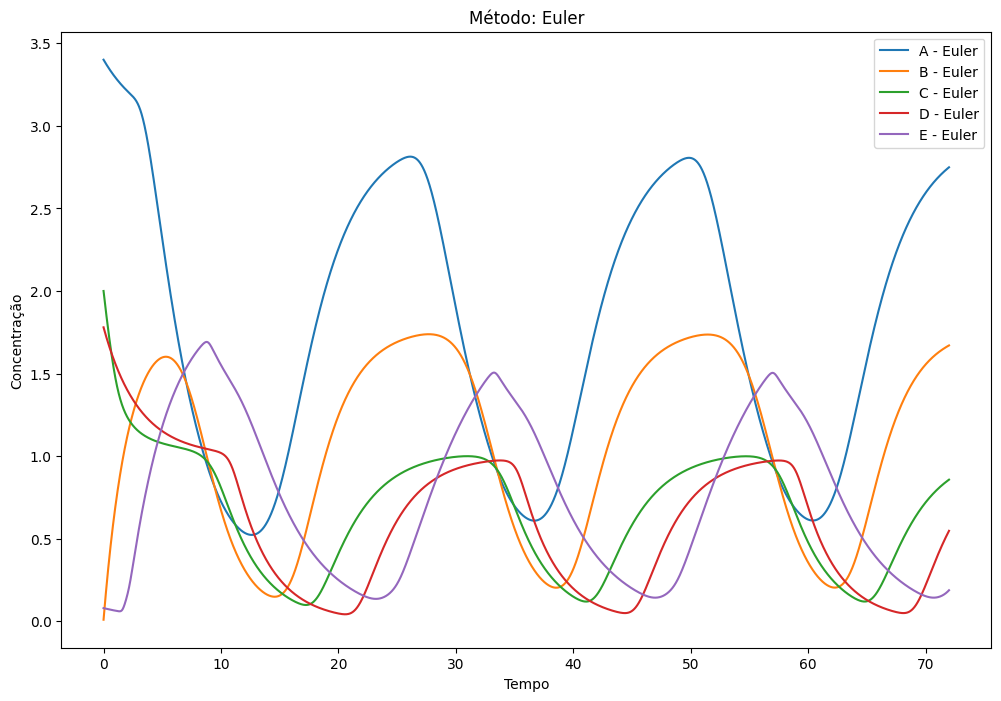

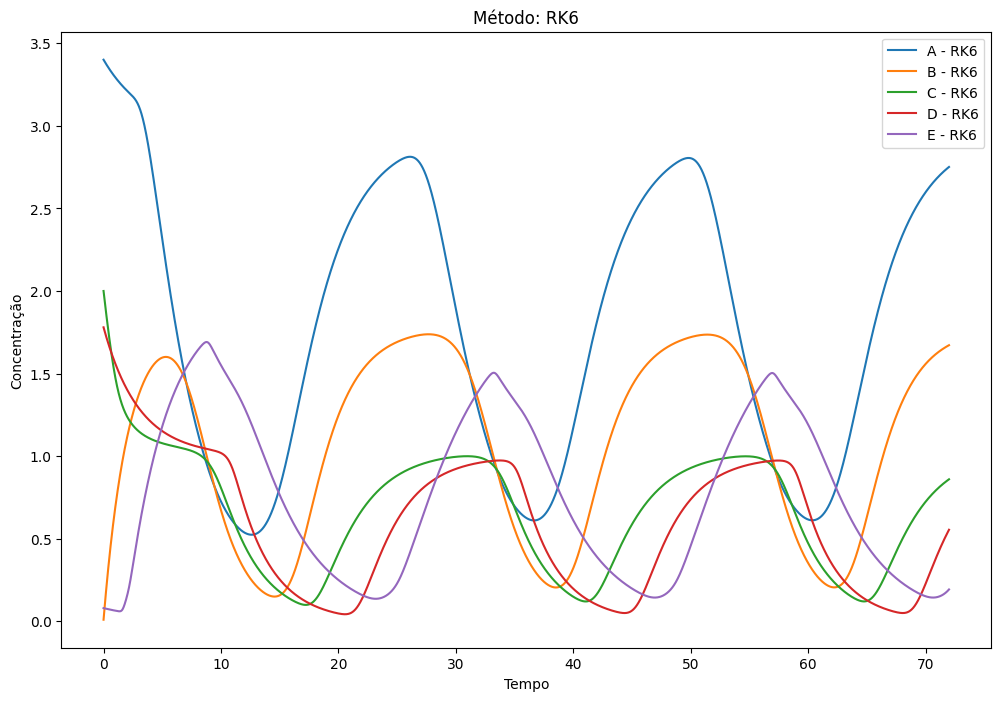

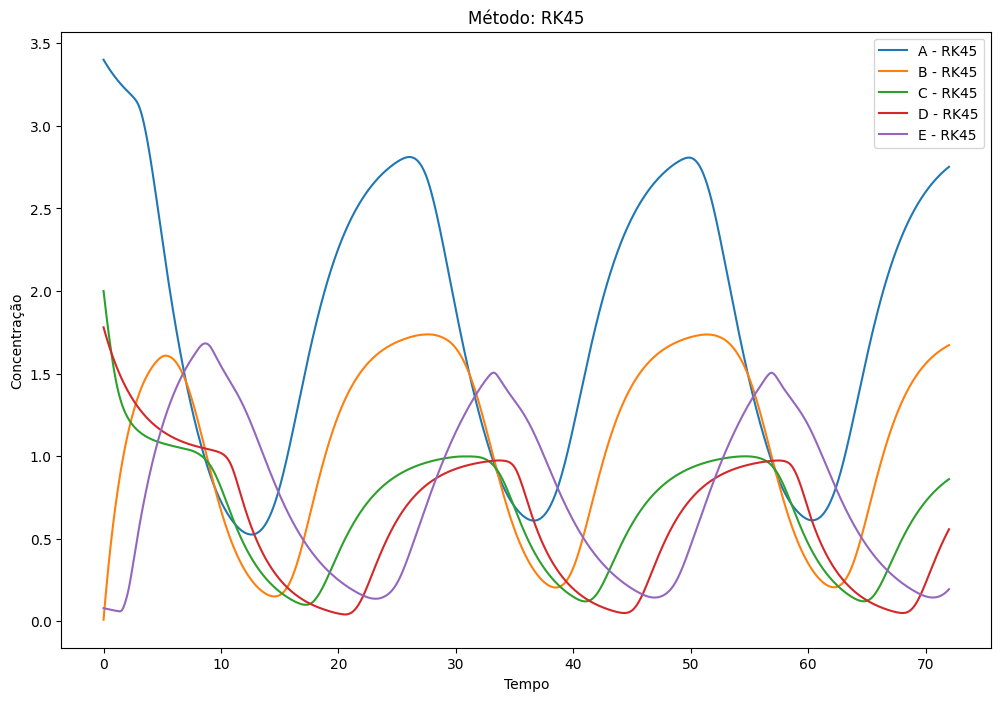

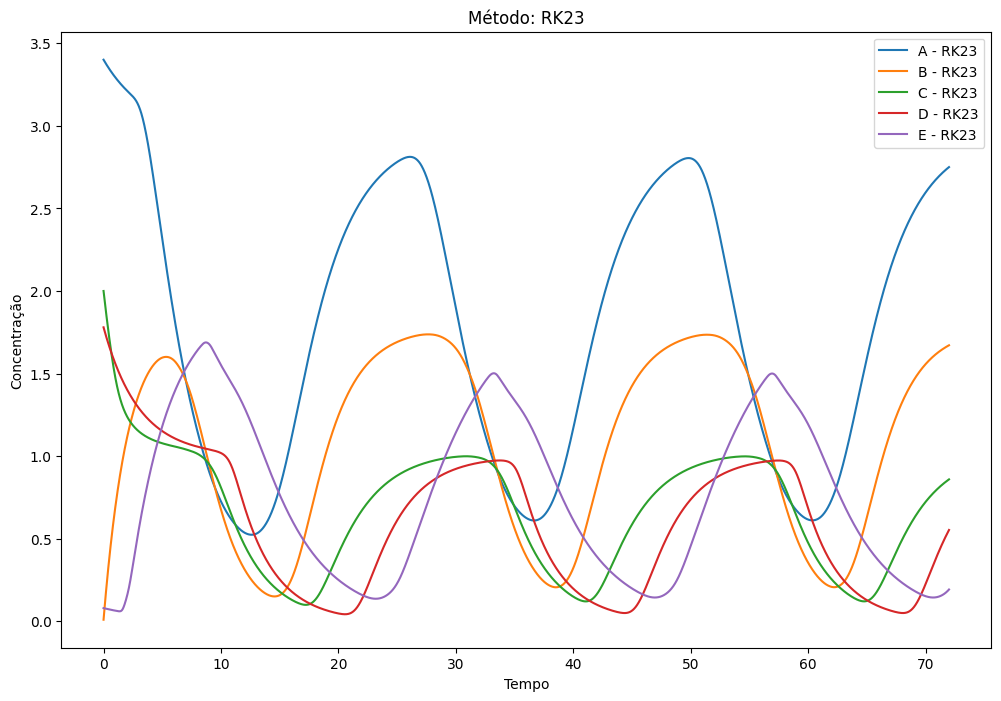

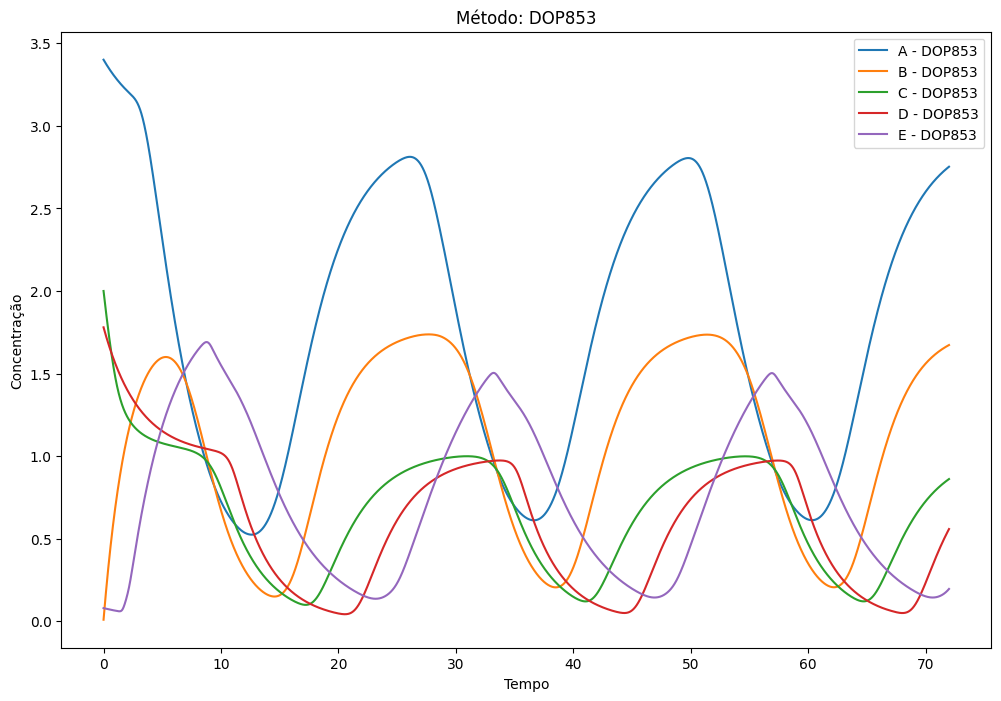

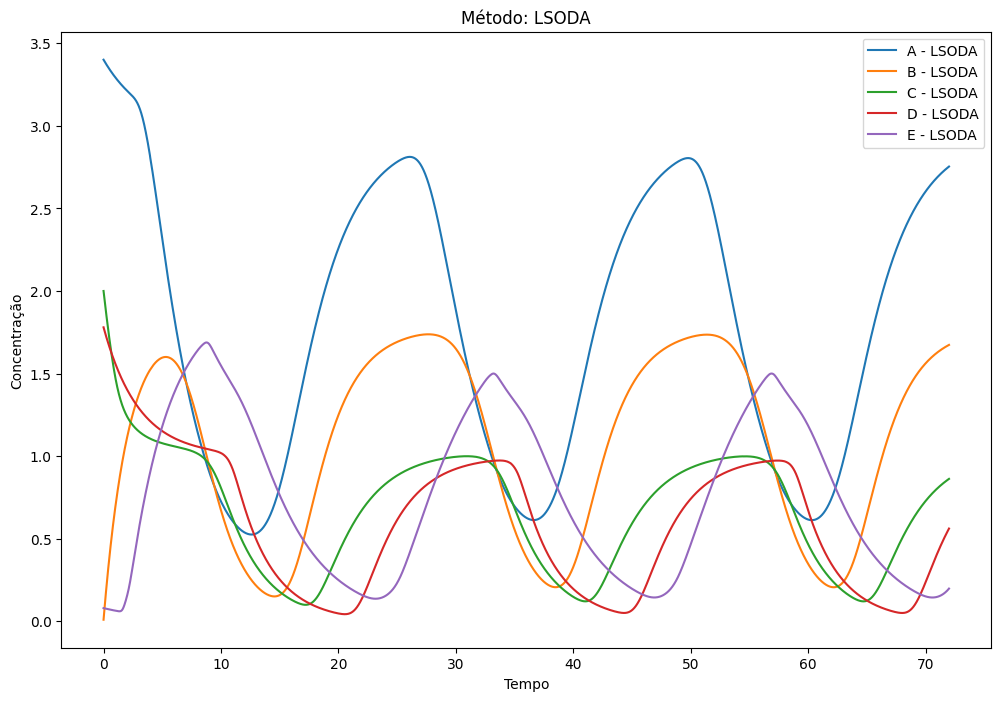

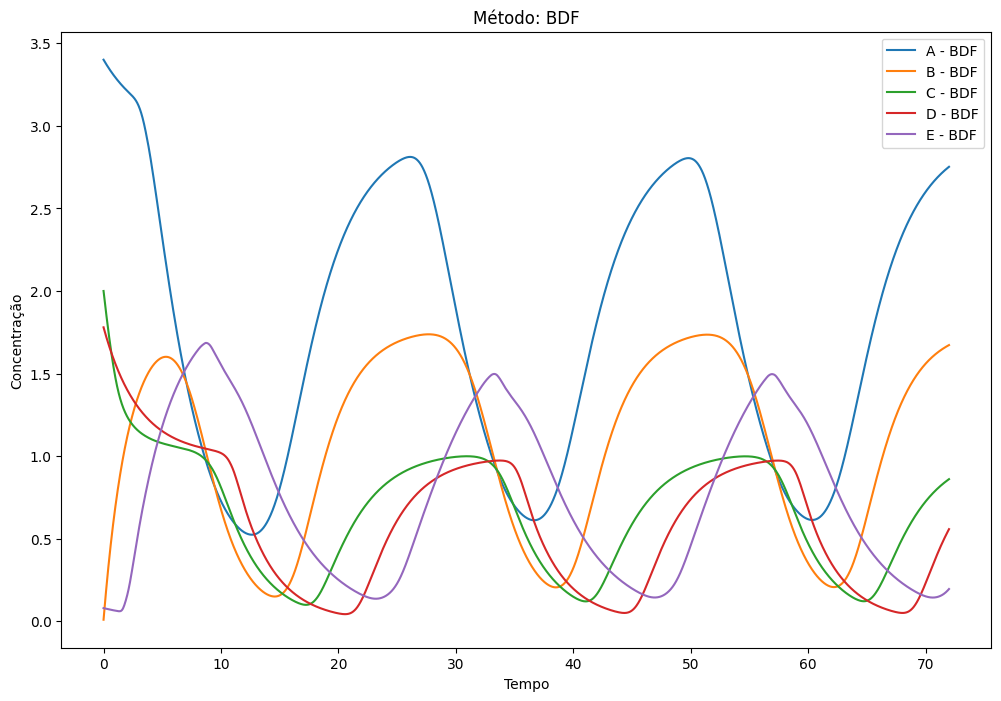

In [29]:
Plotters.plot_methods(results=results,t=t_eval, methods=methods, labels=labels)   

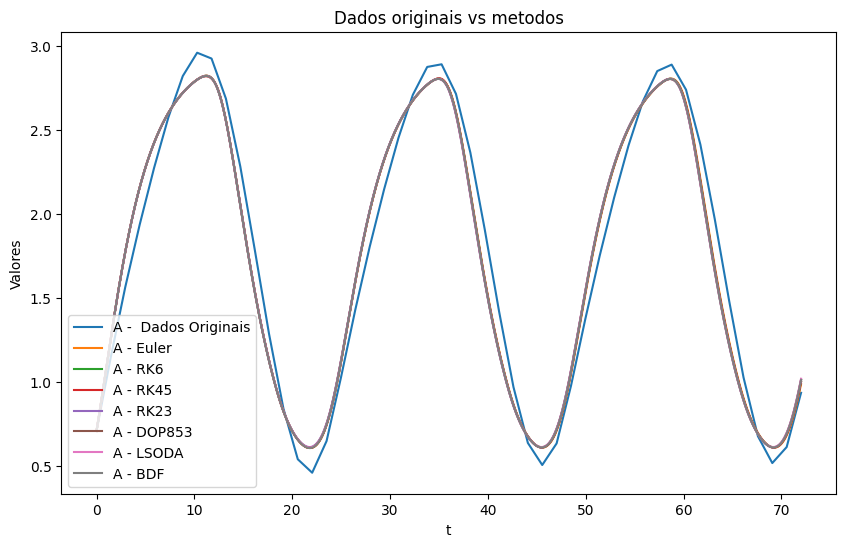

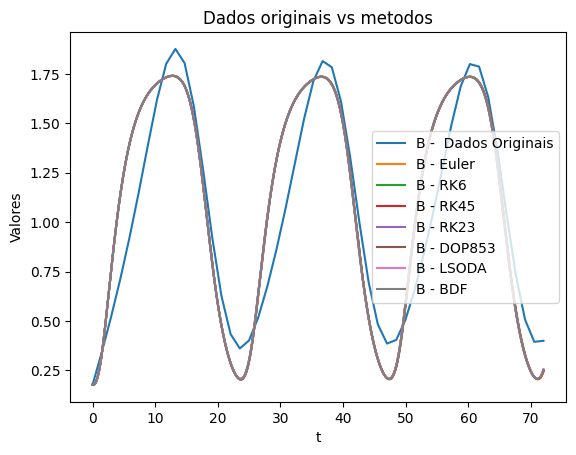

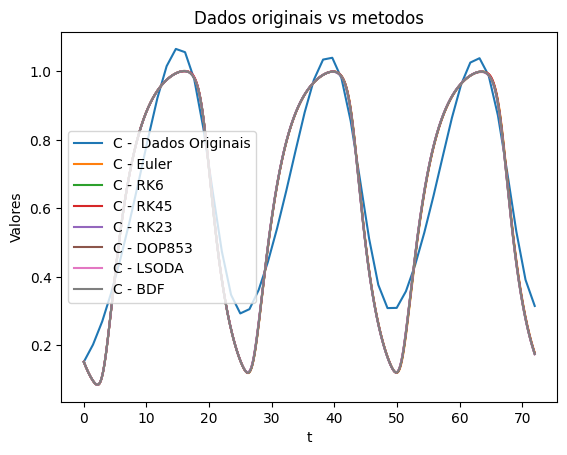

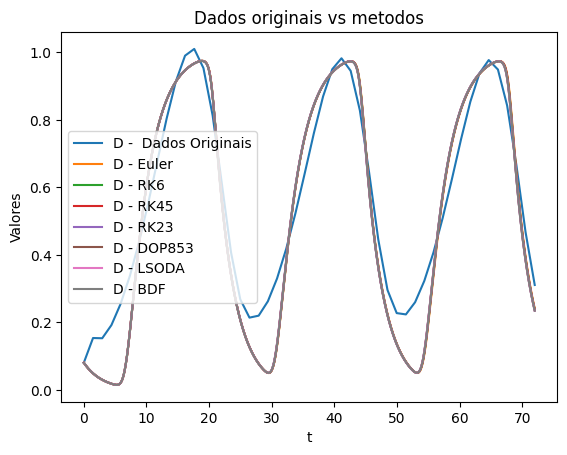

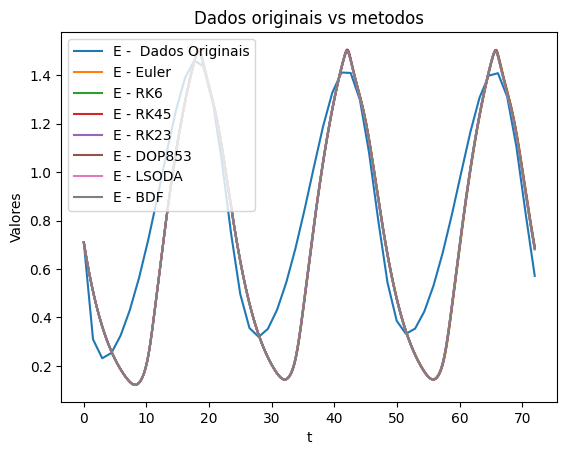

In [18]:
Plotters.plot_comparison(results=results, t=t_eval, df=df, methods=methods, labels=labels)